# 비교 알고리즘

- EpsilonGreedy / Annealing EpsilonGreedy 
- Softmax / Annealing Softmax

In [678]:
import math
import random
import numpy as np


In [679]:
def ind_max(x):
  m = max(x)
  return x.index(m)

def categorical_draw(probs):
  z = random.random()
  cum_prob = 0.0
  for i in range(len(probs)):
    prob = probs[i]
    cum_prob += prob
    if cum_prob > z:
      return i
  
  return len(probs) - 1


# EpsilonGreedy algorithm
class EpsilonGreedy():
  def __init__(self, epsilon, counts, values):
    self.epsilon = epsilon
    self.counts = counts
    self.values = values
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return

  def select_arm(self):
    if random.random() > self.epsilon:
      return ind_max(self.values)
    else:
      return random.randrange(len(self.values))
  
  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]
    
    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

  def run_simul(self, reward) : 
    n_observation = reward.shape[0]; n_arms = reward.shape[1]
    
    rec_reward_get = []; rec_reward_max = []; rec_correct =[]
    for i in range(n_observation) : 
        # choose action
        chosen_arm = self.select_arm()
        best_arm = reward[i].argmax()
        
        # observe and recored outcomes
        reward_get = reward[i,chosen_arm]
        reward_max = max(reward[i])
        

        if chosen_arm == best_arm :
            rec_correct.append(1)
        else :
            rec_correct.append(0)
        
        rec_reward_get.append(reward_get)
        rec_reward_max.append(reward_max)
        
        # update algorithm
        self.update(chosen_arm = chosen_arm, reward = reward_get)
    
    simul_result = pd.DataFrame({'reward':rec_reward_get, 'max':rec_reward_max, 'correct':rec_correct})
    simul_result['regret'] = simul_result['max'] - simul_result['reward']

    return(simul_result)
        
        
        

# Annealing EpsilonGreedy algorithm
class AnnealingEpsilonGreedy():
  def __init__(self, counts, values):
    self.counts = counts
    self.values = values
    return

  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return

  def select_arm(self):
    t = sum(self.counts) + 1
    epsilon = 1 / math.log(t + 0.0000001)
    
    if random.random() > epsilon:
      return ind_max(self.values)
    else:
      return random.randrange(len(self.values))
  
  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]
    
    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

  def run_simul(self, reward) : 
    n_observation = reward.shape[0]; n_arms = reward.shape[1]
    
    rec_reward_get = []; rec_reward_max = []; rec_correct =[]
    for i in range(n_observation) : 
        # choose action
        chosen_arm = self.select_arm()
        best_arm = reward[i].argmax()
        
        # observe and recored outcomes
        reward_get = reward[i,chosen_arm]
        reward_max = max(reward[i])
        

        if chosen_arm == best_arm :
            rec_correct.append(1)
        else :
            rec_correct.append(0)
        
        rec_reward_get.append(reward_get)
        rec_reward_max.append(reward_max)
        
        # update algorithm
        self.update(chosen_arm = chosen_arm, reward = reward_get)
    
    simul_result = pd.DataFrame({'reward':rec_reward_get, 'max':rec_reward_max, 'correct':rec_correct})
    simul_result['regret'] = simul_result['max'] - simul_result['reward']

    return(simul_result)


# Softmax algorithm
class Softmax:
  def __init__(self, temperature, counts, values):
    self.temperature = temperature
    self.counts = counts
    self.values = values
    return
  
  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return
  
  def select_arm(self):
    z = sum([math.exp(v / self.temperature) for v in self.values])
    probs = [math.exp(v / self.temperature) / z for v in self.values]
    return categorical_draw(probs)

  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]
    
    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

  def run_simul(self, reward) : 
    n_observation = reward.shape[0]; n_arms = reward.shape[1]
    
    rec_reward_get = []; rec_reward_max = []; rec_correct =[]
    for i in range(n_observation) : 
        # choose action
        chosen_arm = self.select_arm()
        best_arm = reward[i].argmax()
        
        # observe and recored outcomes
        reward_get = reward[i,chosen_arm]
        reward_max = max(reward[i])
        

        if chosen_arm == best_arm :
            rec_correct.append(1)
        else :
            rec_correct.append(0)
        
        rec_reward_get.append(reward_get)
        rec_reward_max.append(reward_max)
        
        # update algorithm
        self.update(chosen_arm = chosen_arm, reward = reward_get)
    
    simul_result = pd.DataFrame({'reward':rec_reward_get, 'max':rec_reward_max, 'correct':rec_correct})
    simul_result['regret'] = simul_result['max'] - simul_result['reward']

    return(simul_result)

class UCB1():
  def __init__(self, counts, values, alpha): # alpha는 임의로 붙임. bonus의 계수로 붙임. 
    self.counts = counts
    self.values = values
    self.alpha = alpha
    return
  
  def initialize(self, n_arms):
    self.counts = [0 for col in range(n_arms)]
    self.values = [0.0 for col in range(n_arms)]
    return
  
  def select_arm(self):
    n_arms = len(self.counts)
    for arm in range(n_arms):
      if self.counts[arm] == 0:
        return arm

    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(self.counts)
    for arm in range(n_arms):
      bonus = self.alpha * math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
      ucb_values[arm] = self.values[arm] + bonus
    return ind_max(ucb_values)
  
  def update(self, chosen_arm, reward):
    self.counts[chosen_arm] = self.counts[chosen_arm] + 1
    n = self.counts[chosen_arm]

    value = self.values[chosen_arm]
    new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
    self.values[chosen_arm] = new_value
    return

  def run_simul(self, reward) : 
    n_observation = reward.shape[0]; n_arms = reward.shape[1]
    
    rec_reward_get = []; rec_reward_max = []; rec_correct =[]
    for i in range(n_observation) : 
        # choose action
        chosen_arm = self.select_arm()
        best_arm = reward[i].argmax()
        
        # observe and recored outcomes
        reward_get = reward[i,chosen_arm]
        reward_max = max(reward[i])
        

        if chosen_arm == best_arm :
            rec_correct.append(1)
        else :
            rec_correct.append(0)
        
        rec_reward_get.append(reward_get)
        rec_reward_max.append(reward_max)
        
        # update algorithm
        self.update(chosen_arm = chosen_arm, reward = reward_get)
    
    simul_result = pd.DataFrame({'reward':rec_reward_get, 'max':rec_reward_max, 'correct':rec_correct})
    simul_result['regret'] = simul_result['max'] - simul_result['reward']

    return(simul_result)


In [680]:
class LinUCB :
    def __init__(self, alpha, n_features) :
        self.alpha = alpha
        self.n_features = n_features
        return
    
    def initialize(self, n_arms) : 
        self.n_arms = n_arms
        
        self.A = np.array([np.identity(self.n_features)] * n_arms) 
        self.A_inv = np.array([np.identity(self.n_features)] * n_arms) 
        self.b = np.zeros((n_arms, self.n_features, 1))
        
    def select_arm(self,x) :         
        theta = self.A_inv @ self.b 
        UCB = np.transpose(x) @ theta + self.alpha * np.sqrt(np.transpose(x) @ self.A_inv @ x)
        
        return random.sample(list(np.where(UCB == np.max(UCB))[0]),1)[0], theta
        
    def update(self, chosen_arm, x, reward) : 
        x = x.reshape(self.n_features,-1) 
        
        # update A & A_inv
        self.A[chosen_arm] = self.A[chosen_arm] +x @ np.transpose(x)
        self.A_inv[chosen_arm] = np.linalg.inv(self.A[chosen_arm])
        
        # update b
        self.b[chosen_arm] = self.b[chosen_arm]+reward*x
        return 
    
    def run_simul(self, X, reward) : 
        n_observation = reward.shape[0]; n_arms = reward.shape[1]

        rec_reward_get = []; rec_reward_max = []; rec_correct =[]
        for i in range(n_observation) : 
            x = X[i]
            
            # choose action
            chosen_arm, _ = self.select_arm(x)
            best_arm = reward[i].argmax()
            
            # observe and recored outcomes
            reward_get = reward[i,chosen_arm]
            reward_max = max(reward[i])

            if chosen_arm == best_arm :
                rec_correct.append(1)
            else :
                rec_correct.append(0)

            rec_reward_get.append(reward_get)
            rec_reward_max.append(reward_max)

            # update algorithm
            self.update(chosen_arm = chosen_arm, x=x ,reward = reward_get)

        simul_result = pd.DataFrame({'reward':rec_reward_get, 'max':rec_reward_max, 'correct':rec_correct})
        simul_result['regret'] = simul_result['max'] - simul_result['reward']

        return(simul_result)


# Generate Test dataset

In [925]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Data 1 : Iris data + logit

X, y = load_iris(return_X_y=True, as_frame=False) # loading
temp = np.random.permutation(np.arange(150));  # shuffle
X = X[temp] ; y = y[temp] 
scr = StandardScaler()
X = scr.fit_transform(X) # scaling

lr = LogisticRegression(max_iter = 1000000)
lr.fit(X,y)

reward = np.round(lr.predict_proba(X),2)
[len(reward.argmax(axis=1)[reward.argmax(axis=1) ==i])/reward.shape[0] for i in range(reward.shape[1])]

X_1 = X; Reward_1 = reward

####################################################################################


music_trn = pd.read_csv('/Users/pio/Google 드라이브/papers_related/bandit algorithm/music genre classification/train.csv')
music_tst = pd.read_csv('/Users/pio/Google 드라이브/papers_related/bandit algorithm/music genre classification/test.csv')

music_trn = music_trn.dropna(); music_tst = music_tst.dropna()

music_trn_y = music_trn['Class']; music_trn_x = music_trn.drop(['Artist Name', 'Track Name','Class'],axis=1)

music_trn_x = pd.get_dummies(music_trn_x, columns = ['time_signature'], drop_first = True)
music_trn_y = pd.get_dummies(music_trn_y, columns = ['Class'], drop_first = False)


music_tst_x = music_tst.drop(['Artist Name', 'Track Name'],axis=1)
music_tst_x = pd.get_dummies(music_tst_x, columns = ['time_signature'], drop_first = True)

# RF
RF = RandomForestClassifier()
RF.fit(music_trn_x,music_trn_y)

# Generate rewards and X for MAB problem
Reward_2 = RF.predict_proba(music_tst_x)
Reward_2 = np.array([[Reward_2[i][:,1]] for i in range(len(Reward_2))]).reshape(-1,11)

X_2 = np.array(music_tst_x)
 

####################################################################################

music_trn_y = music_trn['Class']

# logit
lr = LogisticRegression(max_iter = 1000000, )
lr.fit(music_trn_x,music_trn_y)

# Generate rewards and X for MAB problem
Reward_3 = lr.predict_proba(music_tst_x)
X_3 = X_2

In [926]:
print(X_1.shape, Reward_1.shape)
print(X_2.shape, Reward_2.shape)
print(X_3.shape, Reward_3.shape)

(150, 4) (150, 3)
(5063, 16) (5063, 11)
(5063, 16) (5063, 11)


In [927]:
print(np.round(pd.Series(Reward_1.argmax(axis=1)).value_counts(sort=False) / Reward_1.shape[0],2))
print(np.round(pd.Series(Reward_2.argmax(axis=1)).value_counts(sort=False) / Reward_2.shape[0],2))
print(np.round(pd.Series(Reward_3.argmax(axis=1)).value_counts(sort=False) / Reward_3.shape[0],2))

0    0.33
1    0.32
2    0.35
dtype: float64
0     0.14
4     0.09
8     0.09
1     0.09
5     0.09
9     0.08
2     0.09
6     0.09
10    0.09
3     0.09
7     0.08
dtype: float64
0     0.01
8     0.00
9     0.00
6     0.01
10    0.86
7     0.12
dtype: float64


In [928]:
lin = LinearRegression()
lin.fit(X_1 , Reward_1[:,0])
print(r2_score(Reward_1[:,0], lin.predict(X_1)))

lin.fit(X_1 , Reward_1[:,1])
print(r2_score(Reward_1[:,1], lin.predict(X_1)))

lin.fit(X_1 , Reward_1[:,2])
print(r2_score(Reward_1[:,2], lin.predict(X_1)))

0.9262255616869943
0.390817349217364
0.7931412125415106


In [685]:
from sklearn.metrics import r2_score
lin = LinearRegression()

for i in range(Reward_2.shape[1]) :     
    lin.fit(X_2 , Reward_2[:,i])
    print(r2_score(Reward_2[:,i], lin.predict(X_2)))

0.004627556262586596
0.00598740689566013
0.004782180767079702
0.004557472140606089
0.004712069424681831
0.002143703896783977
0.0016204710823061186
0.003283679602100298
0.003133069198327121
0.002648807134760678
0.003629642426467794


In [686]:
lin = LinearRegression()

for i in range(Reward_3.shape[1]) :     
    lin.fit(X_2 , Reward_3[:,i])
    print(r2_score(Reward_3[:,i], lin.predict(X_2)))

0.5602549061533308
0.23731817282517664
0.8469450145791942
0.5838857172345677
0.5815802079702402
0.27297449151817055
0.432677540218967
0.5649027311317814
0.9644505125644411
0.3368838668586731
0.7455930977393856


In [870]:
Reward_1.mean(axis=0)

array([0.33326667, 0.33306667, 0.33353333])

In [871]:
Reward_2.mean(axis=0)

array([0.09316702, 0.08805931, 0.08942363, 0.09422282, 0.09339796,
       0.09137001, 0.09296652, 0.08525229, 0.08855025, 0.09246913,
       0.09112106])

In [872]:
Reward_3.mean(axis=0)

array([0.03838744, 0.08996091, 0.07978506, 0.01810506, 0.0083179 ,
       0.04426372, 0.17309261, 0.04217089, 0.13526176, 0.09021449,
       0.28044016])

In [873]:
Reward_1.sum(axis=0)

array([49.99, 49.96, 50.03])

In [874]:
Reward_2.sum(axis=0)

array([471.70460426, 445.84430195, 452.75183333, 477.05013492,
       472.87384921, 462.60638095, 470.6895    , 431.63235967,
       448.32992063, 468.17121032, 461.34590476])

In [875]:
Reward_3.sum(axis=0)

array([ 194.3556028 ,  455.47207149,  403.95175845,   91.66591491,
         42.11354122,  224.10722858,  876.36786478,  213.51122537,
        684.83029795,  456.75597448, 1419.86851997])

# Test on various hyper parameter

In [789]:
# set 1 : X_1 , Reward_1

eps_l = []; mean_regret = []; mean_correct = []
for rep in range(100) :
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]
    for epsilon in np.linspace(0.0, 1, 101) :
        tester_eps = EpsilonGreedy(epsilon=epsilon, counts = None, values = None)
        tester_eps.initialize(n_arms = Temp_Reward.shape[1])
        d_eps1 = tester_eps.run_simul(Temp_X)

        # epsilon별 mean_regret, mean_correct
        eps_l.append(epsilon)
        mean_regret.append(np.mean(d_eps1.regret))
        mean_correct.append(np.mean(d_eps1.correct))
    
set1_eps1 = pd.DataFrame({'eps':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('epsilon greedy : ')
print(set1_eps1[set1_eps1['mean_regret'] == min(set1_eps1['mean_regret'])])
print(set1_eps1[set1_eps1['mean_correct'] == max(set1_eps1['mean_correct'])])
print('#####')

## epsilon greedy + annealing 100번 ** annealing 고정이라 그냥 100번 해봄
eps_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]

    for trying in range(1,101) :
        tester_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
        tester_eps2.initialize(n_arms =Temp_Reward.shape[1])
        d_eps2 = tester_eps2.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        eps_l.append(trying)
        mean_regret.append(np.mean(d_eps2.regret))
        mean_correct.append(np.mean(d_eps2.correct))

set1_eps2 = pd.DataFrame({'i':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})


print('epsilon greedy + annealing : ')
print(set1_eps2[set1_eps2['mean_regret'] == min(set1_eps2['mean_regret'])])
print(set1_eps2[set1_eps2['mean_correct'] == max(set1_eps2['mean_correct'])])
print('#####')

## softmax : exp(-5)~ exp(5)까지 temperature 변화시키면서 확인.
temperature_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]
    
    for temp in np.exp(np.linspace(-5,5,101)) :     
        tester_softmax = Softmax(temperature = temp, counts = None, values = None)
        tester_softmax.initialize(n_arms = Temp_Reward.shape[1])
        d_softmax = tester_softmax.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        temperature_l.append(temp)
        mean_regret.append(np.mean(d_softmax.regret))
        mean_correct.append(np.mean(d_softmax.correct))

set1_softmax= pd.DataFrame({'temp':temperature_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})
    
print('softmax : ')
print(set1_softmax[set1_softmax['mean_regret'] == min(set1_softmax['mean_regret'])])
print(set1_softmax[set1_softmax['mean_correct'] == max(set1_softmax['mean_correct'])])
print('#####')

## ucb1 : alpha 변화시켜가면서 실험.

alpha_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]
    for alpha in np.linspace(0,5,101) :     
        tester_ucb1 = UCB1(counts = None, values = None, alpha = alpha)
        tester_ucb1.initialize(n_arms = Temp_Reward.shape[1])
        d_ucb1 = tester_ucb1.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        alpha_l.append(alpha)
        mean_regret.append(np.mean(d_ucb1.regret))
        mean_correct.append(np.mean(d_ucb1.correct))

set1_ucb1 = pd.DataFrame({'alpha':alpha_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('ucb1 : ')
print(set1_ucb1[set1_ucb1['mean_regret'] == min(set1_ucb1['mean_regret'])])
print(set1_ucb1[set1_ucb1['mean_correct'] == max(set1_ucb1['mean_correct'])])
print('#####')

## linUCB : delta 변화시켜가면서 실험.
delta_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]
    for delta in np.linspace(0.01,1,100) :     
        tester_linUCB = LinUCB(alpha = (1+np.sqrt(np.log(2/delta)/2)), n_features = Temp_X.shape[1])
        tester_linUCB.initialize(n_arms =Temp_Reward.shape[1])

        d_linUCB = tester_linUCB.run_simul(Temp_X, Temp_Reward)
        d_linUCB.sum()

        # delta별 mean_regret, mean_correct
        delta_l.append(delta)
        mean_regret.append(np.mean(d_linUCB.regret))
        mean_correct.append(np.mean(d_linUCB.correct))

set1_linUCB= pd.DataFrame({'delta':delta_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('linUCB : ')
print(set1_linUCB[set1_linUCB['mean_regret'] == min(set1_linUCB['mean_regret'])])
print(set1_linUCB[set1_linUCB['mean_correct'] == max(set1_linUCB['mean_correct'])])
print('#####')



epsilon greedy : 
      eps  mean_regret  mean_correct
3100  0.7     0.626504          0.36
       eps  mean_regret  mean_correct
9364  0.72      0.71254      0.386667
#####
epsilon greedy + annealing : 
       i  mean_regret  mean_correct
5097  98       0.4312      0.473333
       i  mean_regret  mean_correct
5097  98     0.431200      0.473333
6680  81     0.446667      0.473333
#####
softmax : 
         temp  mean_regret  mean_correct
9843  0.67032     0.426467      0.486667
         temp  mean_regret  mean_correct
9843  0.67032     0.426467      0.486667
#####
ucb1 : 
      alpha  mean_regret  mean_correct
3575    2.0     0.439333          0.46
      alpha  mean_regret  mean_correct
9452   2.95       0.4402          0.48
#####
linUCB : 
      delta  mean_regret  mean_correct
9828   0.29     0.480733      0.413333
9834   0.35     0.480733      0.413333
9838   0.39     0.480733      0.413333
9845   0.46     0.480733      0.413333
9846   0.47     0.480733      0.413333
9866   0.67    

In [790]:
# set 2 : X_2 , Reward_2

eps_l = []; mean_regret = []; mean_correct = []
for rep in range(100) :
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]
    for epsilon in np.linspace(0.0, 1, 101) :
        tester_eps = EpsilonGreedy(epsilon=epsilon, counts = None, values = None)
        tester_eps.initialize(n_arms = Temp_Reward.shape[1])
        d_eps1 = tester_eps.run_simul(Temp_Reward)

        # epsilon별 mean_regret, mean_correct
        eps_l.append(epsilon)
        mean_regret.append(np.mean(d_eps1.regret))
        mean_correct.append(np.mean(d_eps1.correct))
    
set2_eps1 = pd.DataFrame({'eps':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('epsilon greedy : ')
print(set2_eps1[set2_eps1['mean_regret'] == min(set2_eps1['mean_regret'])])
print(set2_eps1[set2_eps1['mean_correct'] == max(set2_eps1['mean_correct'])])
print('#####')

## epsilon greedy + annealing 100번 ** annealing 고정이라 그냥 100번 해봄
eps_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]

    for trying in range(1,101) :
        tester_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
        tester_eps2.initialize(n_arms =Temp_Reward.shape[1])
        d_eps2 = tester_eps2.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        eps_l.append(trying)
        mean_regret.append(np.mean(d_eps2.regret))
        mean_correct.append(np.mean(d_eps2.correct))

set2_eps2 = pd.DataFrame({'i':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})


print('epsilon greedy + annealing : ')
print(set2_eps2[set2_eps2['mean_regret'] == min(set2_eps2['mean_regret'])])
print(set2_eps2[set2_eps2['mean_correct'] == max(set2_eps2['mean_correct'])])
print('#####')

## softmax : exp(-5)~ exp(5)까지 temperature 변화시키면서 확인.
temperature_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]
    
    for temp in np.exp(np.linspace(-5,5,101)) :     
        tester_softmax = Softmax(temperature = temp, counts = None, values = None)
        tester_softmax.initialize(n_arms = Temp_Reward.shape[1])
        d_softmax = tester_softmax.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        temperature_l.append(temp)
        mean_regret.append(np.mean(d_softmax.regret))
        mean_correct.append(np.mean(d_softmax.correct))

set2_softmax= pd.DataFrame({'temp':temperature_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})
    
print('softmax : ')
print(set2_softmax[set2_softmax['mean_regret'] == min(set2_softmax['mean_regret'])])
print(set2_softmax[set2_softmax['mean_correct'] == max(set2_softmax['mean_correct'])])
print('#####')

## ucb1 : alpha 변화시켜가면서 실험.

alpha_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]
    for alpha in np.linspace(0,5,101) :     
        tester_ucb1 = UCB1(counts = None, values = None, alpha = alpha)
        tester_ucb1.initialize(n_arms = Temp_Reward.shape[1])
        d_ucb1 = tester_ucb1.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        alpha_l.append(alpha)
        mean_regret.append(np.mean(d_ucb1.regret))
        mean_correct.append(np.mean(d_ucb1.correct))

set2_ucb1 = pd.DataFrame({'alpha':alpha_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('ucb1 : ')
print(set2_ucb1[set2_ucb1['mean_regret'] == min(set2_ucb1['mean_regret'])])
print(set2_ucb1[set2_ucb1['mean_correct'] == max(set2_ucb1['mean_correct'])])
print('#####')

## linUCB : delta 변화시켜가면서 실험.
delta_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]
    for delta in np.linspace(0.01,1,100) :     
        tester_linUCB = LinUCB(alpha = (1+np.sqrt(np.log(2/delta)/2)), n_features = Temp_X.shape[1])
        tester_linUCB.initialize(n_arms =Temp_Reward.shape[1])

        d_linUCB = tester_linUCB.run_simul(Temp_X, Temp_Reward)
        d_linUCB.sum()

        # delta별 mean_regret, mean_correct
        delta_l.append(delta)
        mean_regret.append(np.mean(d_linUCB.regret))
        mean_correct.append(np.mean(d_linUCB.correct))

set2_linUCB= pd.DataFrame({'delta':delta_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('linUCB : ')
print(set2_linUCB[set2_linUCB['mean_regret'] == min(set2_linUCB['mean_regret'])])
print(set2_linUCB[set2_linUCB['mean_correct'] == max(set2_linUCB['mean_correct'])])
print('#####')




epsilon greedy : 
      eps    mean_regret  mean_correct
505   0.0  212165.775127      0.000395
3333  0.0  212165.775127      0.000395
4848  0.0  212165.775127      0.000395
4949  0.0  212165.775127      0.000395
5252  0.0  212165.775127      0.000395
5656  0.0  212165.775127      0.000395
7777  0.0  212165.775127      0.000395
8888  0.0  212165.775127      0.000395
8989  0.0  212165.775127      0.000395
9090  0.0  212165.775127      0.000395
9797  0.0  212165.775127      0.000395
        eps    mean_regret  mean_correct
0      0.00  212165.775127      0.000395
1      0.01  212166.206845      0.000395
2      0.02  212166.522316      0.000395
4      0.04  212167.540541      0.000395
5      0.05  212167.769931      0.000395
...     ...            ...           ...
10064  0.65  212191.796804      0.000395
10071  0.72  212194.222590      0.000395
10075  0.76  212195.808102      0.000395
10076  0.77  212196.269626      0.000395
10087  0.88  212200.365411      0.000395

[3684 rows x 3 column

In [799]:
# set 3 : X_3 , Reward_3

eps_l = []; mean_regret = []; mean_correct = []
for rep in range(100) :
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]
    for epsilon in np.linspace(0.0, 1, 101) :
        tester_eps = EpsilonGreedy(epsilon=epsilon, counts = None, values = None)
        tester_eps.initialize(n_arms = Temp_Reward.shape[1])
        d_eps1 = tester_eps.run_simul(Temp_Reward)

        # epsilon별 mean_regret, mean_correct
        eps_l.append(epsilon)
        mean_regret.append(np.mean(d_eps1.regret))
        mean_correct.append(np.mean(d_eps1.correct))
    
set3_eps1 = pd.DataFrame({'eps':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('epsilon greedy : ')
print(set3_eps1[set3_eps1['mean_regret'] == min(set3_eps1['mean_regret'])])
print(set3_eps1[set3_eps1['mean_correct'] == max(set3_eps1['mean_correct'])])
print('#####')

## epsilon greedy + annealing 100번 ** annealing 고정이라 그냥 100번 해봄
eps_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]

    for trying in range(1,101) :
        tester_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
        tester_eps2.initialize(n_arms =Temp_Reward.shape[1])
        d_eps2 = tester_eps2.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        eps_l.append(trying)
        mean_regret.append(np.mean(d_eps2.regret))
        mean_correct.append(np.mean(d_eps2.correct))

set3_eps2 = pd.DataFrame({'i':eps_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})


print('epsilon greedy + annealing : ')
print(set3_eps2[set3_eps2['mean_regret'] == min(set3_eps2['mean_regret'])])
print(set3_eps2[set3_eps2['mean_correct'] == max(set3_eps2['mean_correct'])])
print('#####')

## softmax : exp(-5)~ exp(5)까지 temperature 변화시키면서 확인.
temperature_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]
    
    for temp in np.exp(np.linspace(-5,5,101)) :     
        tester_softmax = Softmax(temperature = temp, counts = None, values = None)
        tester_softmax.initialize(n_arms = Temp_Reward.shape[1])
        d_softmax = tester_softmax.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        temperature_l.append(temp)
        mean_regret.append(np.mean(d_softmax.regret))
        mean_correct.append(np.mean(d_softmax.correct))

set3_softmax= pd.DataFrame({'temp':temperature_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})
    
print('softmax : ')
print(set3_softmax[set3_softmax['mean_regret'] == min(set3_softmax['mean_regret'])])
print(set3_softmax[set3_softmax['mean_correct'] == max(set3_softmax['mean_correct'])])
print('#####')

## ucb1 : alpha 변화시켜가면서 실험.

alpha_l = []; mean_regret = []; mean_correct = []
for rep in range(100) :
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]
    for alpha in np.linspace(0,5,101) :     
        tester_ucb1 = UCB1(counts = None, values = None, alpha = alpha)
        tester_ucb1.initialize(n_arms = Temp_Reward.shape[1])
        d_ucb1 = tester_ucb1.run_simul(Temp_Reward)

        # try별 mean_regret, mean_correct
        alpha_l.append(alpha)
        mean_regret.append(np.mean(d_ucb1.regret))
        mean_correct.append(np.mean(d_ucb1.correct))

set3_ucb1 = pd.DataFrame({'alpha':alpha_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('ucb1 : ')
print(set3_ucb1[set3_ucb1['mean_regret'] == min(set3_ucb1['mean_regret'])])
print(set3_ucb1[set3_ucb1['mean_correct'] == max(set3_ucb1['mean_correct'])])
print('#####')

## linUCB : delta 변화시켜가면서 실험.
delta_l = []; mean_regret = []; mean_correct = []
for rep in range(100) : 
    print(rep)
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]
    for delta in np.linspace(0.01,1,100) :     
        tester_linUCB = LinUCB(alpha = (1+np.sqrt(np.log(2/delta)/2)), n_features = Temp_X.shape[1])
        tester_linUCB.initialize(n_arms =Temp_Reward.shape[1])

        d_linUCB = tester_linUCB.run_simul(Temp_X, Temp_Reward)
        d_linUCB.sum()

        # delta별 mean_regret, mean_correct
        delta_l.append(delta)
        mean_regret.append(np.mean(d_linUCB.regret))
        mean_correct.append(np.mean(d_linUCB.correct))

set3_linUCB= pd.DataFrame({'delta':delta_l, 'mean_regret':mean_regret,'mean_correct':mean_correct})

print('linUCB : ')
print(set3_linUCB[set3_linUCB['mean_regret'] == min(set3_linUCB['mean_regret'])])
print(set3_linUCB[set3_linUCB['mean_correct'] == max(set3_linUCB['mean_correct'])])
print('#####')




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
epsilon greedy : 
       eps  mean_regret  mean_correct
2627  0.01     0.040821      0.847521
       eps  mean_regret  mean_correct
2627  0.01     0.040821      0.847521
#####
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
epsilon greedy + annealing : 
       i  mean_regret  mean_correct
4359  60     0.060343      0.767134
       i  mean_regret  mean_correct
4359  60     0.060343      0.767134
#####
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24

In [801]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='eps', ylabel='mean_regret'>

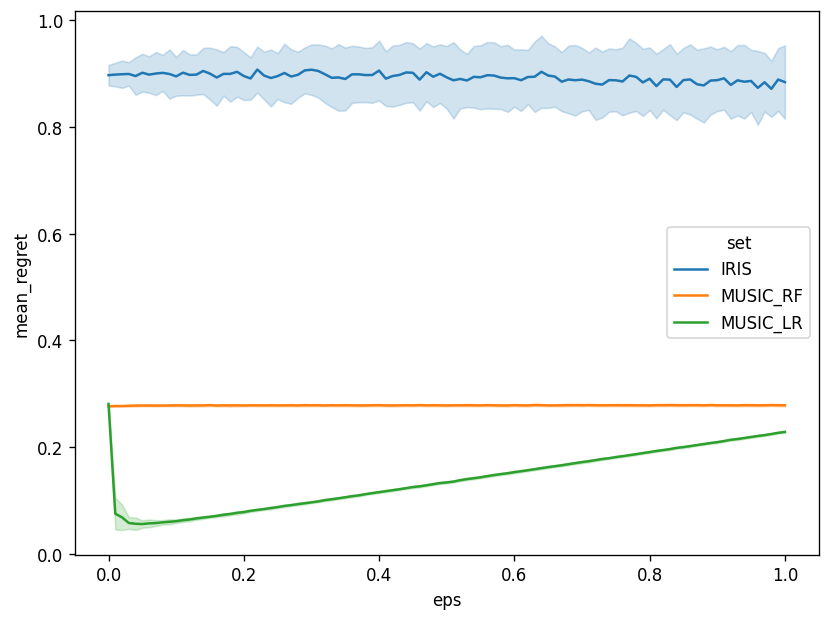

In [804]:
set1_eps1['set'] = 'IRIS'
set2_eps1['set'] = 'MUSIC_RF'
set3_eps1['set'] = 'MUSIC_LR'

eps1_concat = pd.concat([set1_eps1,set2_eps1,set3_eps1]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'eps',y = 'mean_regret', hue='set', ci='sd', data= eps1_concat)

<AxesSubplot:xlabel='i', ylabel='mean_regret'>

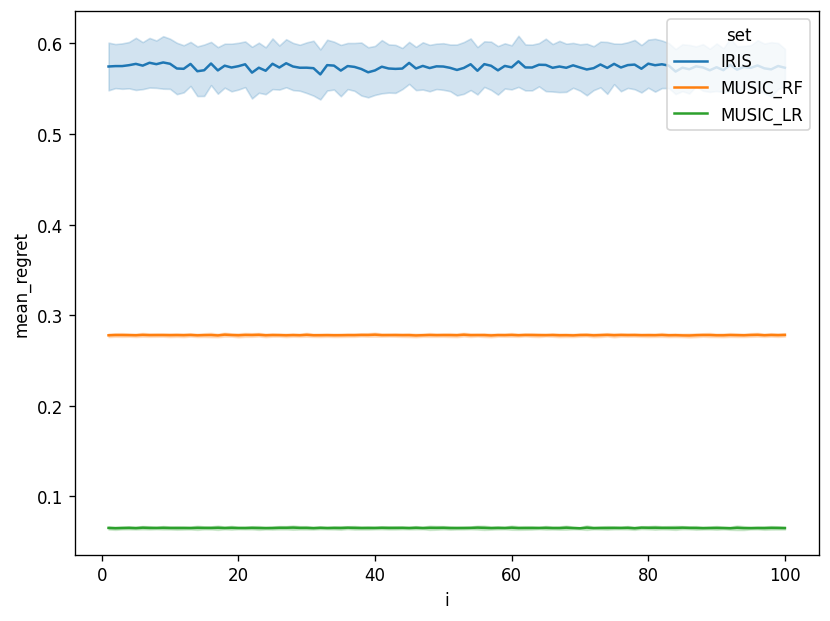

In [806]:
set1_eps2['set'] = 'IRIS'
set2_eps2['set'] = 'MUSIC_RF'
set3_eps2['set'] = 'MUSIC_LR'

eps2_concat = pd.concat([set1_eps2,set2_eps2,set3_eps2]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'i',y = 'mean_regret', hue='set', ci='sd',data= eps2_concat)

<AxesSubplot:xlabel='log_temperature', ylabel='mean_regret'>

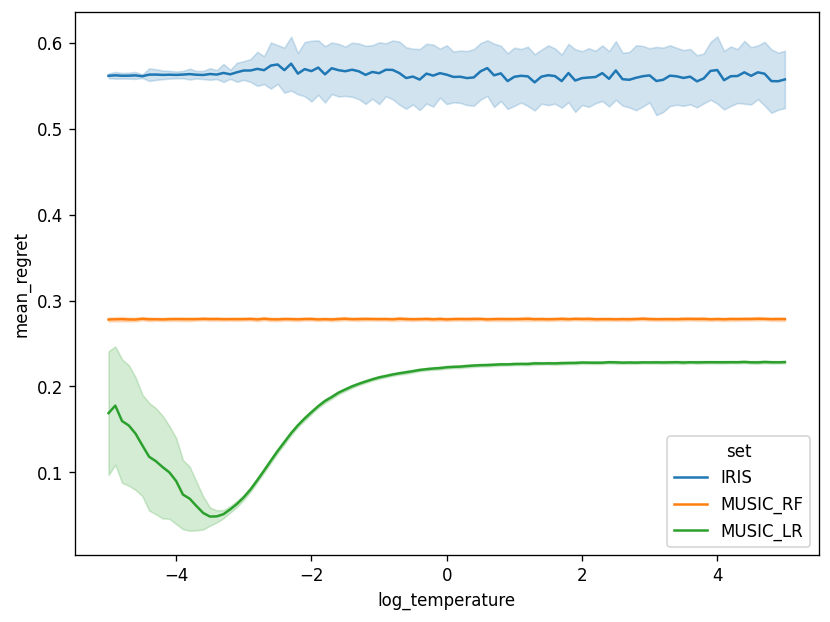

In [809]:
set1_softmax['log_temperature'] = np.log(set1_softmax['temp'])
set2_softmax['log_temperature'] = np.log(set2_softmax['temp'])
set3_softmax['log_temperature'] = np.log(set3_softmax['temp'])

set1_softmax['set'] = 'IRIS'
set2_softmax['set'] = 'MUSIC_RF'
set3_softmax['set'] = 'MUSIC_LR'

softmax_concat = pd.concat([set1_softmax,set2_softmax,set3_softmax]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'log_temperature',y = 'mean_regret', hue='set', ci='sd', data= softmax_concat)

<AxesSubplot:xlabel='alpha', ylabel='mean_regret'>

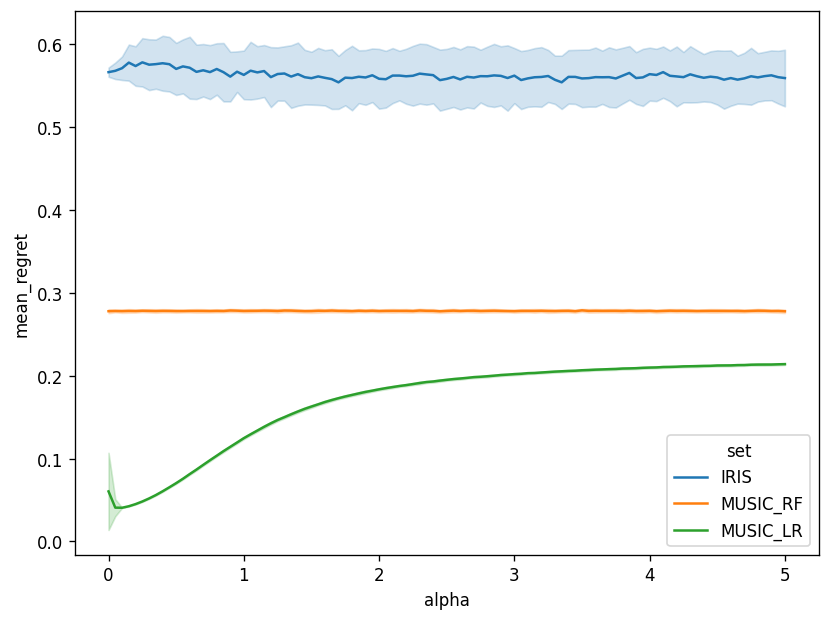

In [810]:
set1_ucb1['set'] = 'IRIS'
set2_ucb1['set'] = 'MUSIC_RF'
set3_ucb1['set'] = 'MUSIC_LR'

ucb1_concat = pd.concat([set1_ucb1,set2_ucb1,set3_ucb1]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'alpha',y = 'mean_regret', hue='set',  ci='sd',data= ucb1_concat)

<AxesSubplot:xlabel='delta', ylabel='mean_regret'>

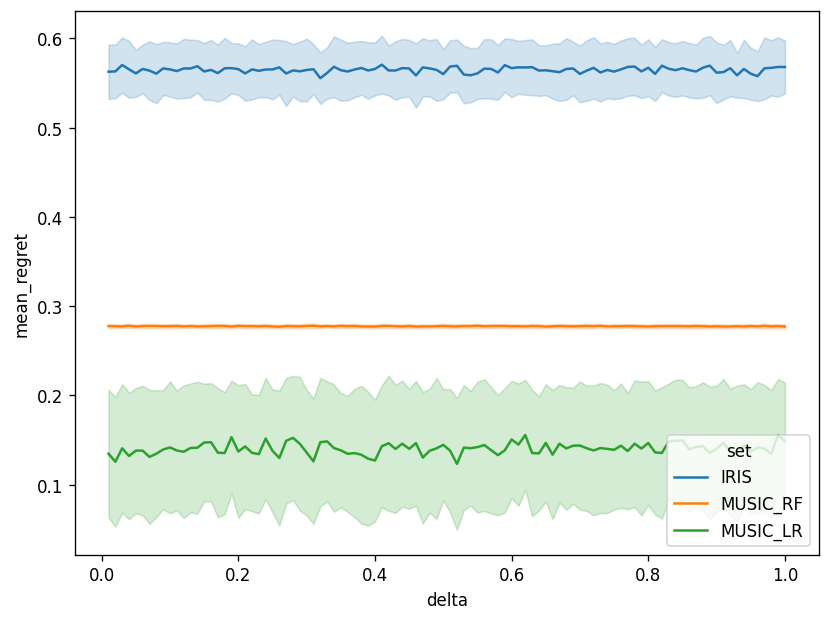

In [811]:
set1_linUCB['set'] = 'IRIS'
set2_linUCB['set'] = 'MUSIC_RF'
set3_linUCB['set'] = 'MUSIC_LR'

linUCB_concat = pd.concat([set1_linUCB,set2_linUCB,set3_linUCB]).reset_index(drop=True)

plt.figure(figsize=(8, 6), dpi=120)
sns.lineplot(x = 'delta',y = 'mean_regret', hue='set',  ci='sd',data= linUCB_concat)

# 이제 hyperparam 고정하고 각 data Set에서 알고리즘 비교

In [930]:
set_1_experiment = pd.DataFrame()
for i in range(100) : 
    print(i)
    idx_shfl = np.random.permutation(np.arange(Reward_1.shape[0]))
    Temp_Reward = Reward_1[idx_shfl,:]
    Temp_X = X_1[idx_shfl,:]

    set1_t_eps1 = EpsilonGreedy(epsilon=0.05, counts = None, values = None)
    set1_t_eps1.initialize(n_arms = Temp_Reward.shape[1])
    set1_t_eps1_simul = set1_t_eps1.run_simul(Temp_Reward)


    set1_t_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
    set1_t_eps2.initialize(n_arms = Temp_Reward.shape[1])
    set1_t_eps2_simul = set1_t_eps2.run_simul(Temp_Reward)

    set1_t_softmax = Softmax(temperature = 0.05, counts = None, values = None)
    set1_t_softmax.initialize(n_arms = Temp_Reward.shape[1])
    set1_t_softmax_simul = set1_t_softmax.run_simul(Temp_Reward)

    set1_t_ucb1 = UCB1(counts = None, values = None, alpha = 1)
    set1_t_ucb1.initialize(n_arms = Temp_Reward.shape[1])
    set1_t_ucb1_simul = set1_t_ucb1.run_simul(Temp_Reward)


    set1_t_linucb = LinUCB(alpha = (1+np.sqrt(np.log(2/0.1)/2)), n_features = Temp_X.shape[1])
    set1_t_linucb.initialize(n_arms =Temp_Reward.shape[1])
    set1_t_linucb_simul = set1_t_linucb.run_simul(Temp_X, Temp_Reward)

    set1_t_opt_return = np.cumsum(set1_t_eps1_simul['max']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_eps1_return = np.cumsum(set1_t_eps1_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_eps2_return = np.cumsum(set1_t_eps2_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_softmax_return = np.cumsum(set1_t_softmax_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_ucb1_return = np.cumsum(set1_t_ucb1_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)
    set1_t_linucb_return = np.cumsum(set1_t_linucb_simul['reward']) / (np.array(set1_t_eps1_simul.index)+1)

    set1_t_concat = pd.concat([pd.DataFrame({'Model':'OPT','step':np.arange(1,151),'mean return':set1_t_opt_return}),
                               pd.DataFrame({'Model':'EPS1','step':np.arange(1,151),'mean return':set1_t_eps1_return}),
                               pd.DataFrame({'Model':'EPS2','step':np.arange(1,151),'mean return':set1_t_eps2_return}),
                               pd.DataFrame({'Model':'SOFTMAX','step':np.arange(1,151),'mean return':set1_t_softmax_return}),
                               pd.DataFrame({'Model':'UCB1','step':np.arange(1,151),'mean return':set1_t_ucb1_return}),
                               pd.DataFrame({'Model':'LINUCB','step':np.arange(1,151),'mean return':set1_t_linucb_return})],axis=0).reset_index(drop=True)

    set_1_experiment = set_1_experiment.append(set1_t_concat)





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<AxesSubplot:xlabel='step', ylabel='mean return'>

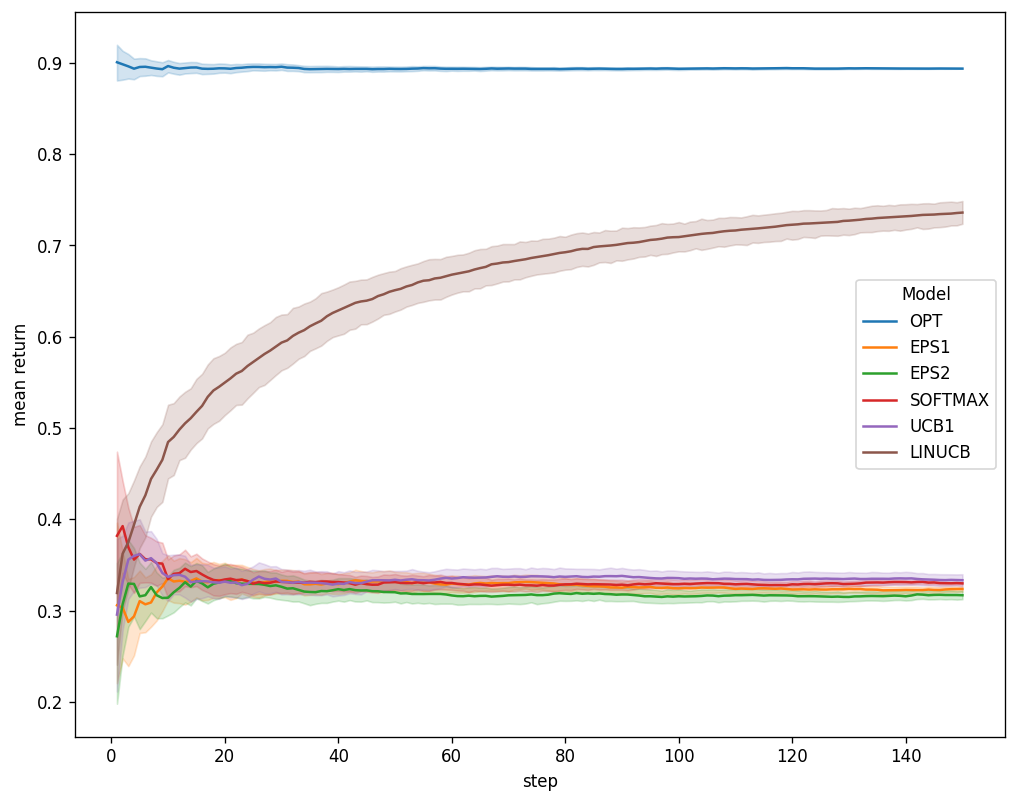

In [931]:
set_1_experiment = set_1_experiment.reset_index()
plt.figure(figsize=(10, 8), dpi=120)
sns.lineplot(x = 'step',y = 'mean return', hue='Model', data= set_1_experiment, legend='brief')



In [932]:
set_2_experiment = pd.DataFrame()
for i in range(100) : 
    print(i)
    idx_shfl = np.random.permutation(np.arange(Reward_2.shape[0]))
    Temp_Reward = Reward_2[idx_shfl,:]
    Temp_X = X_2[idx_shfl,:]

    set2_t_eps1 = EpsilonGreedy(epsilon=0.05, counts = None, values = None)
    set2_t_eps1.initialize(n_arms = Temp_Reward.shape[1])
    set2_t_eps1_simul = set2_t_eps1.run_simul(Temp_Reward)


    set2_t_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
    set2_t_eps2.initialize(n_arms = Temp_Reward.shape[1])
    set2_t_eps2_simul = set2_t_eps2.run_simul(Temp_Reward)

    set2_t_softmax = Softmax(temperature = 0.05, counts = None, values = None)
    set2_t_softmax.initialize(n_arms = Temp_Reward.shape[1])
    set2_t_softmax_simul = set2_t_softmax.run_simul(Temp_Reward)

    set2_t_ucb1 = UCB1(counts = None, values = None, alpha = 1)
    set2_t_ucb1.initialize(n_arms = Temp_Reward.shape[1])
    set2_t_ucb1_simul = set2_t_ucb1.run_simul(Temp_Reward)


    set2_t_linucb = LinUCB(alpha = (1+np.sqrt(np.log(2/0.1)/2)), n_features = Temp_X.shape[1])
    set2_t_linucb.initialize(n_arms =Temp_Reward.shape[1])
    set2_t_linucb_simul = set2_t_linucb.run_simul(Temp_X, Temp_Reward)

    set2_t_opt_return = np.cumsum(set2_t_eps1_simul['max']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_eps1_return = np.cumsum(set2_t_eps1_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_eps2_return = np.cumsum(set2_t_eps2_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_softmax_return = np.cumsum(set2_t_softmax_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_ucb1_return = np.cumsum(set2_t_ucb1_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)
    set2_t_linucb_return = np.cumsum(set2_t_linucb_simul['reward']) / (np.array(set2_t_eps1_simul.index)+1)

    set2_t_concat = pd.concat([pd.DataFrame({'Model':'OPT','step':np.arange(1,5064),'mean return':set2_t_opt_return}),
                               pd.DataFrame({'Model':'EPS1','step':np.arange(1,5064),'mean return':set2_t_eps1_return}),
                               pd.DataFrame({'Model':'EPS2','step':np.arange(1,5064),'mean return':set2_t_eps2_return}),
                               pd.DataFrame({'Model':'SOFTMAX','step':np.arange(1,5064),'mean return':set2_t_softmax_return}),
                               pd.DataFrame({'Model':'UCB1','step':np.arange(1,5064),'mean return':set2_t_ucb1_return}),
                               pd.DataFrame({'Model':'LINUCB','step':np.arange(1,5064),'mean return':set2_t_linucb_return})],axis=0).reset_index(drop=True)

    set_2_experiment = set_2_experiment.append(set2_t_concat)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<AxesSubplot:xlabel='step', ylabel='mean return'>

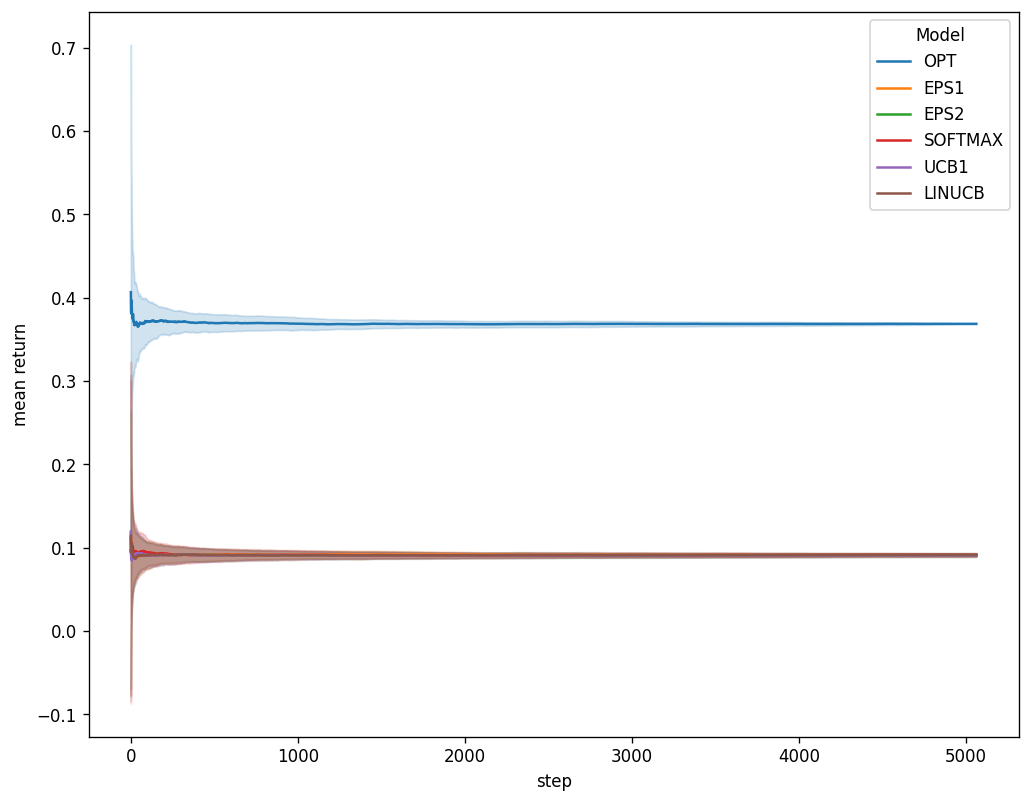

In [933]:
set_2_experiment = set_2_experiment.reset_index()
plt.figure(figsize=(10, 8), dpi=120)
sns.lineplot(x = 'step',y = 'mean return', hue='Model', data= set_2_experiment, ci='sd', legend='brief')

In [934]:
set_3_experiment = pd.DataFrame()
for i in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]

    set3_t_eps1 = EpsilonGreedy(epsilon=0.05, counts = None, values = None)
    set3_t_eps1.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_eps1_simul = set3_t_eps1.run_simul(Temp_Reward)


    set3_t_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
    set3_t_eps2.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_eps2_simul = set3_t_eps2.run_simul(Temp_Reward)

    set3_t_softmax = Softmax(temperature = 0.05, counts = None, values = None)
    set3_t_softmax.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_softmax_simul = set3_t_softmax.run_simul(Temp_Reward)

    set3_t_ucb1 = UCB1(counts = None, values = None, alpha = 1)
    set3_t_ucb1.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_ucb1_simul = set3_t_ucb1.run_simul(Temp_Reward)


    set3_t_linucb = LinUCB(alpha = (1+np.sqrt(np.log(2/0.1)/2)), n_features = Temp_X.shape[1])
    set3_t_linucb.initialize(n_arms =Temp_Reward.shape[1])
    set3_t_linucb_simul = set3_t_linucb.run_simul(Temp_X, Temp_Reward)

    set3_t_opt_return = np.cumsum(set3_t_eps1_simul['max']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_eps1_return = np.cumsum(set3_t_eps1_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_eps2_return = np.cumsum(set3_t_eps2_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_softmax_return = np.cumsum(set3_t_softmax_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_ucb1_return = np.cumsum(set3_t_ucb1_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_linucb_return = np.cumsum(set3_t_linucb_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)

    set3_t_concat = pd.concat([pd.DataFrame({'Model':'OPT','step':np.arange(1,5064),'mean return':set3_t_opt_return}),
                               pd.DataFrame({'Model':'EPS1','step':np.arange(1,5064),'mean return':set3_t_eps1_return}),
                               pd.DataFrame({'Model':'EPS2','step':np.arange(1,5064),'mean return':set3_t_eps2_return}),
                               pd.DataFrame({'Model':'SOFTMAX','step':np.arange(1,5064),'mean return':set3_t_softmax_return}),
                               pd.DataFrame({'Model':'UCB1','step':np.arange(1,5064),'mean return':set3_t_ucb1_return}),
                               pd.DataFrame({'Model':'LINUCB','step':np.arange(1,5064),'mean return':set3_t_linucb_return})],axis=0).reset_index(drop=True)

    set_3_experiment = set_3_experiment.append(set3_t_concat)





<AxesSubplot:xlabel='step', ylabel='mean return'>

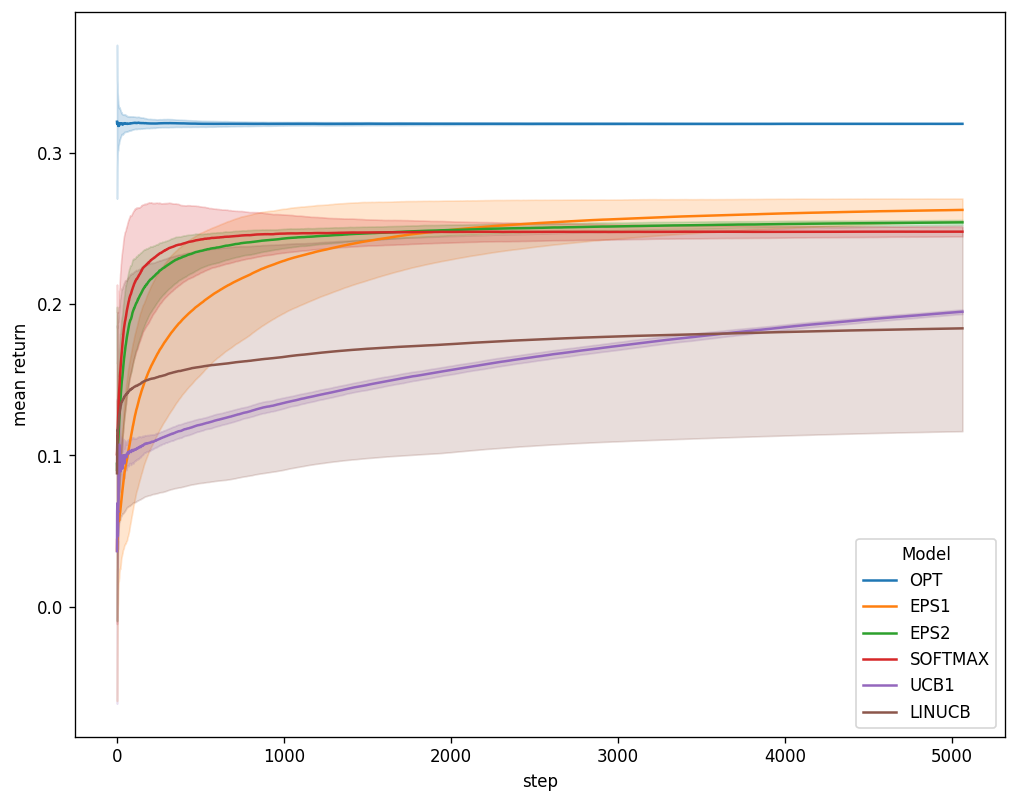

In [935]:
set_3_experiment =set_3_experiment.reset_index()
plt.figure(figsize=(10, 8), dpi=120)
sns.lineplot(x = 'step',y = 'mean return', hue='Model', data= set_3_experiment, ci='sd', legend='brief')




# Worst case test

In [900]:
set_3_experiment = pd.DataFrame()
for i in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_3.shape[0]))
    Temp_Reward = Reward_3[idx_shfl,:]
    Temp_X = X_3[idx_shfl,:]

    set3_t_eps1 = EpsilonGreedy(epsilon=0.5, counts = None, values = None)
    set3_t_eps1.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_eps1_simul = set3_t_eps1.run_simul(Temp_Reward)


    set3_t_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
    set3_t_eps2.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_eps2_simul = set3_t_eps2.run_simul(Temp_Reward)

    set3_t_softmax = Softmax(temperature = 1, counts = None, values = None)
    set3_t_softmax.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_softmax_simul = set3_t_softmax.run_simul(Temp_Reward)

    set3_t_ucb1 = UCB1(counts = None, values = None, alpha = 1)
    set3_t_ucb1.initialize(n_arms = Temp_Reward.shape[1])
    set3_t_ucb1_simul = set3_t_ucb1.run_simul(Temp_Reward)


    set3_t_linucb = LinUCB(alpha = (1+np.sqrt(np.log(2/0.1)/2)), n_features = Temp_X.shape[1])
    set3_t_linucb.initialize(n_arms =Temp_Reward.shape[1])
    set3_t_linucb_simul = set3_t_linucb.run_simul(Temp_X, Temp_Reward)

    set3_t_opt_return = np.cumsum(set3_t_eps1_simul['max']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_eps1_return = np.cumsum(set3_t_eps1_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_eps2_return = np.cumsum(set3_t_eps2_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_softmax_return = np.cumsum(set3_t_softmax_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_ucb1_return = np.cumsum(set3_t_ucb1_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)
    set3_t_linucb_return = np.cumsum(set3_t_linucb_simul['reward']) / (np.array(set3_t_eps1_simul.index)+1)

    set3_t_concat = pd.concat([pd.DataFrame({'Model':'OPT','step':np.arange(1,5064),'mean return':set3_t_opt_return}),
                               pd.DataFrame({'Model':'EPS1','step':np.arange(1,5064),'mean return':set3_t_eps1_return}),
                               pd.DataFrame({'Model':'EPS2','step':np.arange(1,5064),'mean return':set3_t_eps2_return}),
                               pd.DataFrame({'Model':'SOFTMAX','step':np.arange(1,5064),'mean return':set3_t_softmax_return}),
                               pd.DataFrame({'Model':'UCB1','step':np.arange(1,5064),'mean return':set3_t_ucb1_return}),
                               pd.DataFrame({'Model':'LINUCB','step':np.arange(1,5064),'mean return':set3_t_linucb_return})],axis=0).reset_index(drop=True)

    set_3_experiment = set_3_experiment.append(set3_t_concat)






<AxesSubplot:xlabel='step', ylabel='mean return'>

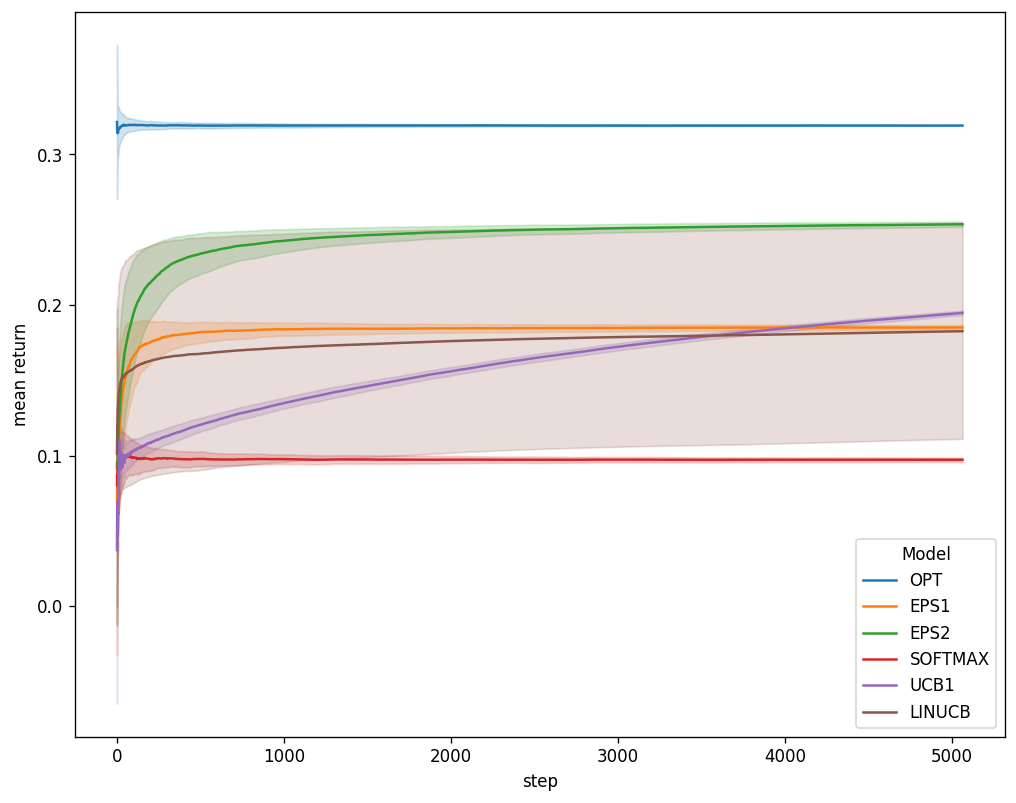

In [901]:
set_3_experiment =set_3_experiment.reset_index()
plt.figure(figsize=(10, 8), dpi=120)
sns.lineplot(x = 'step',y = 'mean return', hue='Model', data= set_3_experiment, ci='sd', legend='brief')





# Try new - Music Genre LR 2

In [909]:
lin = LinearRegression()

for i in range(Reward_3.shape[1]) :     
    lin.fit(X_2 , Reward_3[:,i])
    print(r2_score(Reward_3[:,i], lin.predict(X_2)))

0.5602549061533308
0.23731817282517664
0.8469450145791942
0.5838857172345677
0.5815802079702402
0.27297449151817055
0.432677540218967
0.5649027311317814
0.9644505125644411
0.3368838668586731
0.7455930977393856


In [936]:
lin = LinearRegression()

for i in range(Reward_4.shape[1]) :     
    lin.fit(X_4 , Reward_4[:,i])
    print(r2_score(Reward_4[:,i], lin.predict(X_4)))

0.8469450145791942
0.9644505125644411
0.7455930977393856


In [914]:
X_4 = X_2
Reward_4 = Reward_3[:,[2,8,10]]

In [916]:
set_4_experiment = pd.DataFrame()
for i in range(100) : 
    idx_shfl = np.random.permutation(np.arange(Reward_4.shape[0]))
    Temp_Reward = Reward_4[idx_shfl,:]
    Temp_X = X_4[idx_shfl,:]

    set4_t_eps1 = EpsilonGreedy(epsilon=0.05, counts = None, values = None)
    set4_t_eps1.initialize(n_arms = Temp_Reward.shape[1])
    set4_t_eps1_simul = set4_t_eps1.run_simul(Temp_Reward)


    set4_t_eps2 = AnnealingEpsilonGreedy(counts = None, values = None)
    set4_t_eps2.initialize(n_arms = Temp_Reward.shape[1])
    set4_t_eps2_simul = set4_t_eps2.run_simul(Temp_Reward)

    set4_t_softmax = Softmax(temperature = 0.05, counts = None, values = None)
    set4_t_softmax.initialize(n_arms = Temp_Reward.shape[1])
    set4_t_softmax_simul = set4_t_softmax.run_simul(Temp_Reward)

    set4_t_ucb1 = UCB1(counts = None, values = None, alpha = 1)
    set4_t_ucb1.initialize(n_arms = Temp_Reward.shape[1])
    set4_t_ucb1_simul = set4_t_ucb1.run_simul(Temp_Reward)


    set4_t_linucb = LinUCB(alpha = (1+np.sqrt(np.log(2/0.1)/2)), n_features = Temp_X.shape[1])
    set4_t_linucb.initialize(n_arms =Temp_Reward.shape[1])
    set4_t_linucb_simul = set4_t_linucb.run_simul(Temp_X, Temp_Reward)

    set4_t_opt_return = np.cumsum(set4_t_eps1_simul['max']) / (np.array(set4_t_eps1_simul.index)+1)
    set4_t_eps1_return = np.cumsum(set4_t_eps1_simul['reward']) / (np.array(set4_t_eps1_simul.index)+1)
    set4_t_eps2_return = np.cumsum(set4_t_eps2_simul['reward']) / (np.array(set4_t_eps1_simul.index)+1)
    set4_t_softmax_return = np.cumsum(set4_t_softmax_simul['reward']) / (np.array(set4_t_eps1_simul.index)+1)
    set4_t_ucb1_return = np.cumsum(set4_t_ucb1_simul['reward']) / (np.array(set4_t_eps1_simul.index)+1)
    set4_t_linucb_return = np.cumsum(set4_t_linucb_simul['reward']) / (np.array(set4_t_eps1_simul.index)+1)

    set4_t_concat = pd.concat([pd.DataFrame({'Model':'OPT','step':np.arange(1,5064),'mean return':set4_t_opt_return}),
                               pd.DataFrame({'Model':'EPS1','step':np.arange(1,5064),'mean return':set4_t_eps1_return}),
                               pd.DataFrame({'Model':'EPS2','step':np.arange(1,5064),'mean return':set4_t_eps2_return}),
                               pd.DataFrame({'Model':'SOFTMAX','step':np.arange(1,5064),'mean return':set4_t_softmax_return}),
                               pd.DataFrame({'Model':'UCB1','step':np.arange(1,5064),'mean return':set4_t_ucb1_return}),
                               pd.DataFrame({'Model':'LINUCB','step':np.arange(1,5064),'mean return':set4_t_linucb_return})],axis=0).reset_index(drop=True)

    set_4_experiment = set_4_experiment.append(set4_t_concat)







In [918]:
set_4_experiment

,index,Model,step,mean return
0,0,OPT,1,0.369023
1,1,OPT,2,0.328534
2,2,OPT,3,0.325194
3,3,OPT,4,0.319557
4,4,OPT,5,0.319297
...,...,...,...,...
3037795,30373,LINUCB,5059,0.279783
3037796,30374,LINUCB,5060,0.279777
3037797,30375,LINUCB,5061,0.279797
3037798,30376,LINUCB,5062,0.279820


<AxesSubplot:xlabel='step', ylabel='mean return'>

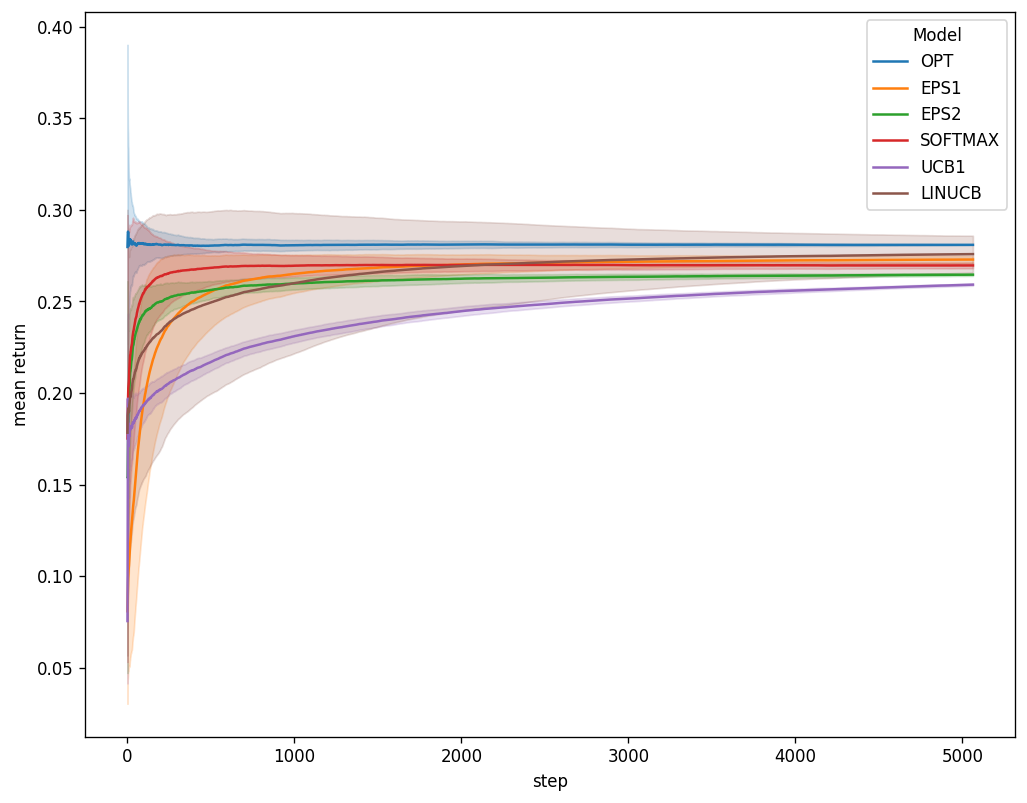

In [917]:
set_4_experiment =set_4_experiment.reset_index()
plt.figure(figsize=(10, 8), dpi=120)
sns.lineplot(x = 'step',y = 'mean return', hue='Model', data= set_4_experiment, ci='sd', legend='brief')